### Задачи исследования

1. изучение имеющихся данных
2. предобработка данных (пропуски, некорректные типы данных, дубликаты)
3. feature engineering (год, месяц, число, цены квадратного метра, отношение площади кухни к общей)
4. построение линейной регрессии для прогнозирования стоимости схожих квартир
5. выводы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
import statsmodels.formula.api as smf 

import warnings
warnings.filterwarnings('ignore')

## Изучение имеющихся данных

In [2]:
data = pd.read_csv('russia_real_estate.csv')
# url: https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021
data.head()

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,12:04:54,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,15:44:00,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,11:24:52,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,17:42:43,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


- date - date of publication of the announcement (дата публикации объявления);
- time - the time when the ad was published (время публикации объявления);
- geo_lat - Latitude (широта)
- geo_lon - Longitude (долгота)
- region - Region of Russia (регион России). There are 85 subjects in the country in total.
- building_type - Facade type (тип фасада). 0 - Other. 1 - Panel. 2 - Monolithic. 3 - Brick. 4 - Blocky. 5 - Wooden
- object_type - Apartment type (тип квартиры: новостройка/вторичка). 1 - Secondary real estate market; 2 - New building;
- level - Apartment floor (этаж)
- levels - Number of storeys (количество этажей в доме)
- rooms - the number of living rooms (количество жилых комнат). If the value is "-1", then it means "studio apartment"
- area - the total area of the apartment (общая площадь квартиры)
- kitchen_area - Kitchen area (площадь кухни)
- price - Price. in rubles (цена в рублях)

## Предобработка данных

In [4]:
# пропусков нет
data.isnull().sum()

price            0
date             0
time             0
geo_lat          0
geo_lon          0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
dtype: int64

In [5]:
data.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06
mean,4.422029e+06,5.403826e+01,5.324433e+01,4.307141e+03,1.948966e+00,6.214530e+00,1.139892e+01,1.726173e+00,5.391825e+01,1.062840e+01,3.945399e+00
std,2.150752e+07,4.622758e+00,2.074763e+01,3.308050e+03,1.038537e+00,4.957419e+00,6.535734e+00,1.082133e+00,3.335293e+01,9.792380e+00,4.558357e+00
min,-2.144967e+09,4.145906e+01,1.989020e+01,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,7.000000e-02,1.000000e-02,1.000000e+00
25%,1.950000e+06,5.337768e+01,3.777790e+01,2.661000e+03,1.000000e+00,2.000000e+00,5.000000e+00,1.000000e+00,3.800000e+01,7.000000e+00,1.000000e+00
50%,2.990000e+06,5.517139e+01,4.306774e+01,2.922000e+03,2.000000e+00,5.000000e+00,1.000000e+01,2.000000e+00,4.802000e+01,9.700000e+00,1.000000e+00
75%,4.802000e+06,5.622613e+01,6.564895e+01,6.171000e+03,3.000000e+00,9.000000e+00,1.600000e+01,2.000000e+00,6.313000e+01,1.270000e+01,1.100000e+01
max,2.147484e+09,7.198040e+01,1.625361e+02,6.188800e+04,5.000000e+00,3.900000e+01,3.900000e+01,1.000000e+01,7.856000e+03,9.999000e+03,1.100000e+01


**Аномалии**

- Минимальное количество комнат - -2
- Цена меньше 0 руб
- Цена больше 2_000_000_000 руб
- Площадь кухни больше или равна общей площади квартиры
- Этаж квартиры больше общего количества этажей
- Тип квартиры "11", а должен быть "2"

In [6]:
# установим границы для устранения аномалий

MIN_AREA = 20 
MAX_AREA = 200

MIN_KITCHEN = 3
MAX_KITCHEN = 30

MIN_PRICE = 1_000_000
MAX_PRICE = 50_000_000

MIN_ROOMS = 1
MAX_ROOMS = 5

In [7]:
# устраняем аномалии связанные с площадью квартиры
data = data[(data['area'] >= MIN_AREA) & (data['area'] <= MAX_AREA)]

# устраняем аномалии связанные с площадью кухни
data = data[(data['kitchen_area'] >= MIN_KITCHEN) & (data['kitchen_area'] <= MAX_KITCHEN)]  

# устраняем аномалии связанные со стоимостью квартиры
data = data[(data['price'] >= MIN_PRICE) & (data['price'] <= MAX_PRICE)]  

# устраняем аномалии связанные с количеством комнат
data = data[(data['rooms'] >= MIN_ROOMS) & (data['rooms'] <= MAX_ROOMS)]  

# устраняем аномалии связанные с этажами 
data = data[data['level'] <= data['levels']] 

# устраняем аномалии связанные с типом квартиры 
data[data['object_type'] == 11] = 2

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4920185 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 525.5+ MB


In [8]:
data['date'] = pd.to_datetime(data['date'])

После устранение выбросов количество записей уменьшилось с 5.5 млн до 4.5 млн :)

## Feature engineering

In [9]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# этаж квартиры по отношению к общему количеству этажей
data['level_to_levels'] = data['level'] / data['levels']

# средняя площадь комнаты в квартире
data['avg_room_size'] = data['area'] / data['rooms']

# доля кухни в обшей площади
data['kitchen_share'] = data['kitchen_area'] / data['area']

In [10]:
moscow_df = data[data['region'] == 81]  # в данном датасете регион Москвы - 81 :/
kremlin_coords = (55.7520, 37.6175)
moscow_df['dist_to_center_of_Moscow'] = moscow_df.apply(lambda x: geopy.distance.geodesic((x.geo_lat, x.geo_lon), kremlin_coords).km, axis=1)

In [11]:
moscow_df = moscow_df.drop(['date', 'time', 'geo_lat', 'geo_lon', 'region'] , axis=1)
moscow_df.head()

,price,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,day,level_to_levels,avg_room_size,kitchen_share,dist_to_center_of_Moscow
1,8650000,3,5,24,2,69.1,12.0,1,2018,2,27,0.208333,34.55,0.173661,21.501874
4,5450000,3,13,14,2,60.0,10.0,1,2018,3,1,0.928571,30.00,0.166667,29.562649
5,3300000,1,4,5,1,32.0,6.0,1,2018,3,2,0.800000,32.00,0.187500,18.688728
9,2800000,1,9,10,2,55.0,8.0,1,2018,3,6,0.900000,27.50,0.145455,77.200247
27,5300000,3,2,5,3,75.0,9.0,1,2018,3,30,0.400000,25.00,0.120000,100.862982


In [12]:
# удаляем лишние колонки
data = data.drop(['date', 'time', 'geo_lat', 'geo_lon'] , axis=1)

In [13]:
data.head()

,price,region,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,day,level_to_levels,avg_room_size,kitchen_share
0,6050000,2661,1,8,10,3,82.6,10.8,1,2018,2,19,0.800000,27.533333,0.130751
1,8650000,81,3,5,24,2,69.1,12.0,1,2018,2,27,0.208333,34.550000,0.173661
2,4000000,2871,1,5,9,3,66.0,10.0,1,2018,2,28,0.555556,22.000000,0.151515
3,2,2,2,2,2,2,2.0,2.0,2,1970,1,1,1.000000,1.000000,1.000000
4,5450000,81,3,13,14,2,60.0,10.0,1,2018,3,1,0.928571,30.000000,0.166667


## Визуализация данных

Text(0.5, 1.0, 'Распределение стоимости квартир')

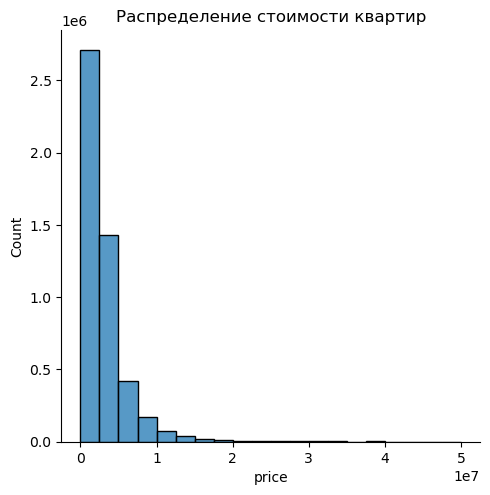

In [14]:
sns.displot(data.price, bins=20)
plt.title("Распределение стоимости квартир")

Text(0.5, 1.0, 'Площадь квартиры')

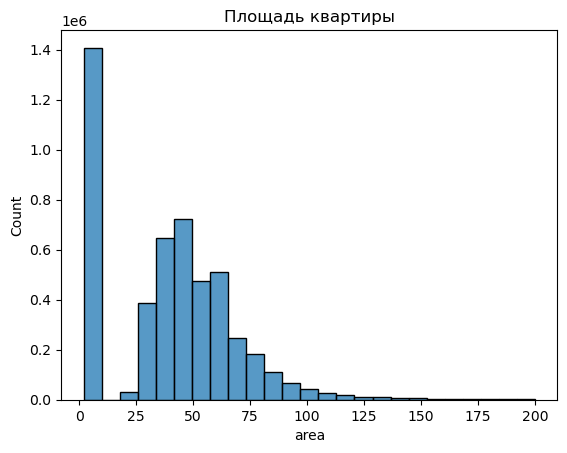

In [15]:
sns.histplot(data['area'], bins=25)
plt.title('Площадь квартиры')

Text(0.5, 1.0, 'Тип фасада')

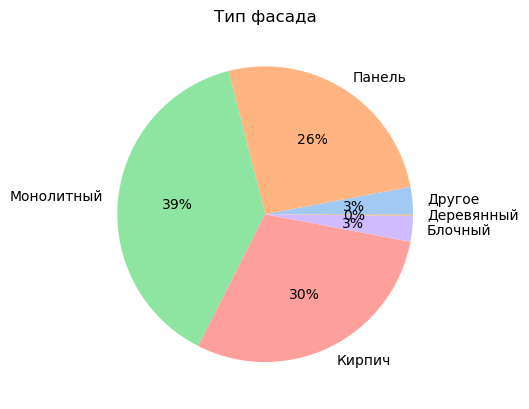

In [16]:
building_types = data['building_type'].value_counts().sort_index(ascending=True)
colors = sns.color_palette('pastel')[0:6]
labels = ['Другое', 'Панель', 'Монолитный', 'Кирпич', 'Блочный', 'Деревянный']
plt.pie(building_types, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Тип фасада')

Text(0.5, 1.0, 'Тип квартиры')

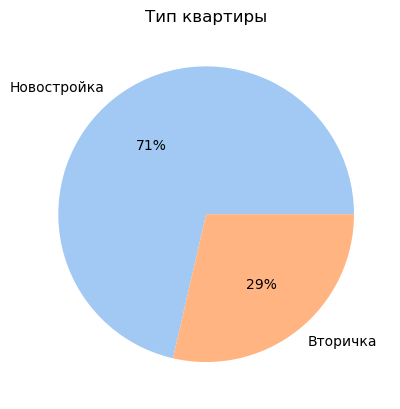

In [17]:
obj_types = data['object_type'].value_counts()
labels = ['Новостройка', 'Вторичка']
colors = sns.color_palette('pastel')[0:2]
plt.pie(obj_types, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('Тип квартиры')

Text(0.5, 1.0, 'Количество комнат')

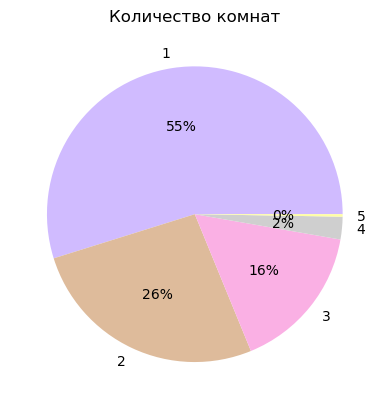

In [18]:
rooms = data['rooms'].value_counts()
colors = sns.color_palette('pastel')[4:9]
labels = ['1', '2', '3', '4', '5']
plt.pie(rooms, labels=labels, colors=colors, autopct="%.0f%%")
plt.title('Количество комнат')


## Корреляция

<Axes: >

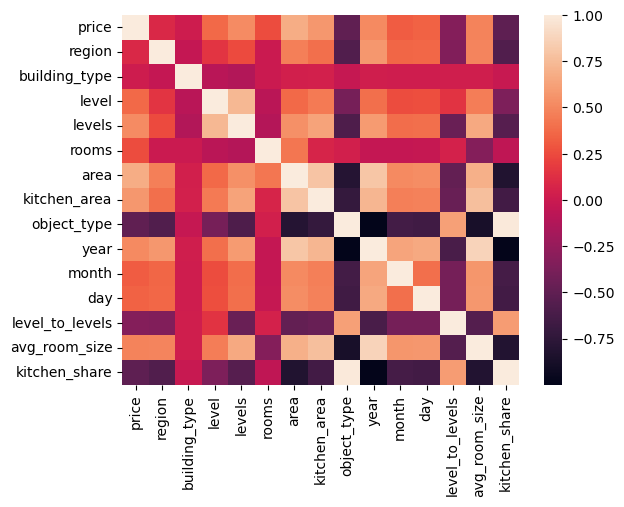

In [19]:
correlation = data.corr()
sns.heatmap(correlation)

In [20]:
correlation[correlation['price'] > 0.1]['price'].sort_values(ascending=False)

price            1.000000
area             0.678714
kitchen_area     0.572719
levels           0.516221
year             0.509087
avg_room_size    0.481792
level            0.369746
day              0.336276
month            0.312757
rooms            0.253041
Name: price, dtype: float64

Наибольшая корреляция стоимости квартиры с площадью квартиры, площадью кухни и количеством этажей.

# Построение регрессии

In [21]:
results_moscow = smf.ols(
    f'price ~ building_type + rooms + area + kitchen_area + object_type + level_to_levels + dist_to_center_of_Moscow', 
    moscow_df).fit()
results_moscow.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                 1.096e+05
Date:                Sun, 16 Jul 2023   Prob (F-statistic):               0.00
Time:                        19:50:53   Log-Likelihood:            -5.6934e+06
No. Observations:              363105   AIC:                         1.139e+07
Df Residuals:                  363098   BIC:                         1.139e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 8.306e+05   6507.664    127.629      0.000    8.18e+05    8.43e+05
building_type            -5.216e+04   2749.532    -18.970      0.000   -5.75e+04   -4.68e+04
rooms                    -2.976e+05   6071.690    -49.014      0.000   -3.09e+05   -2.86e+05
area                      8.972e+04    308.012    291.283      0.000    8.91e+04    9.03e+04
kitchen_area              7.479e+04    999.839     74.805      0.000    7.28e+04    7.68e+04
object_type               8.306e+05   6507.664    127.629      0.000    8.18e+05    8.43e+05
level_to_levels          -1.028e+05   8997.449    -11.427      0.000    -1.2e+05   -8.52e+04
dist_to_center_of_Moscow -3.667e+04     94.094   -389.670      0.000   -3.68e+04   -3.65e+04
==============================================================================
Omnibus:                   278159.977   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26583770.911
Skew:                           3.019   Prob(JB):                         0.00
Kurtosis:                      44.481   Cond. No.                     2.37e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.57e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Ререссия через sklearn**

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [23]:
column_names = [
    'building_type', 'level', 'levels', 'rooms', 'area',
    'kitchen_area', 'object_type', 'year', 'month', 'day',
    'level_to_levels', 'avg_room_size', 'kitchen_share',
    'dist_to_center_of_Moscow'
]

X = moscow_df[column_names]
y = moscow_df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.7, random_state=1)

lin_model = LinearRegression(fit_intercept=False).fit(X_train, Y_train)

lin_model.fit(X_train, Y_train)
y_predicted = lin_model.predict(X_test)
print(f"MSE = {mean_squared_error(Y_test, y_predicted)}")
print(f"R^2 = {r2_score(Y_test, y_predicted)}")

MSE = 2054229971506.6882
R^2 = 0.6976613253089808


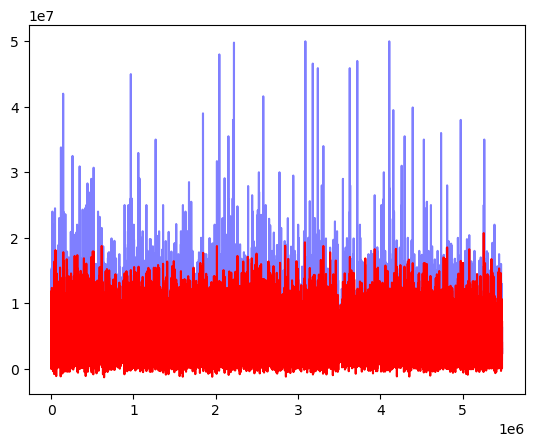

In [24]:
plt.plot(X_test.sort_index().index, Y_test, c='b', alpha=0.5)
plt.plot(X_test.sort_index().index, y_predicted, c='r')

**$L_2$-регуляризация**

In [25]:
from sklearn.model_selection import GridSearchCV

column_names = [
    'building_type', 'level', 'levels', 'rooms', 'area',
    'kitchen_area', 'object_type', 'year', 'month', 'day',
    'level_to_levels', 'avg_room_size', 'kitchen_share',
    'dist_to_center_of_Moscow'
]

X = moscow_df[column_names]
y = moscow_df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.7, random_state=1)

grid = GridSearchCV(Lasso(), {'alpha': np.linspace(1, 3, 10)})
grid.fit(X_train, Y_train)
print(grid.best_params_)

{'alpha': 1.0}


In [26]:
lasso_model = Lasso(alpha=1)

lasso_model.fit(X_train, Y_train)

l2_res = lasso_model.predict(X_test)

print(f"MSE = {mean_squared_error(Y_test, l2_res)}")
print(f"R^2 = {r2_score(Y_test, l2_res)}")

MSE = 2054231286912.422
R^2 = 0.6976611317094171


**$L_1$-регуляризация**

In [27]:
# с L1-Регуляризацией 
column_names = [
    'building_type', 'level', 'levels', 'rooms', 'area',
    'kitchen_area', 'object_type', 'year', 'month', 'day',
    'level_to_levels', 'avg_room_size', 'kitchen_share',
    'dist_to_center_of_Moscow'
]

X = moscow_df[column_names]
y = moscow_df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.7, random_state=1)


grid = GridSearchCV(Ridge(), {'alpha': np.linspace(-10, 10, 20)})
grid.fit(X_train, Y_train)
print(grid.best_params_)

{'alpha': 10.0}


In [28]:
grid = GridSearchCV(Ridge(), {'alpha': np.linspace(10, 100, 20)})
grid.fit(X_train, Y_train)
print(grid.best_params_)

{'alpha': 57.368421052631575}


In [29]:
ridge_model = Ridge(alpha=57)

ridge_model.fit(X_train, Y_train)

l1_res = ridge_model.predict(X_test)

print(f"MSE = {mean_squared_error(Y_test, l1_res)}")
print(f"R^2 = {r2_score(Y_test, l1_res)}")

MSE = 2054334169896.3062
R^2 = 0.6976459895367163


L1- и L2-регуляризации в данном случае неуместны, без них коэффициент детерминации $R^2$ только больше, а MSE - меньше.

### Прогнозирование стоимости квартиры в Москве

In [30]:
column_names = [
    'building_type', 'level', 'levels', 'rooms', 'area',
    'kitchen_area', 'object_type', 'year', 'month', 'day',
    'level_to_levels', 'avg_room_size', 'kitchen_share',
    'dist_to_center_of_Moscow'
]
coeffs = pd.DataFrame([lin_model.coef_], columns=column_names, index=['coefs']).T
coeffs

,coefs
building_type,2.762167e+04
level,8.985454e+03
levels,6.742925e+04
rooms,-8.185418e+05
area,1.030086e+05
kitchen_area,5.212126e+04
object_type,-1.174195e+09
year,5.825820e+05
month,3.794804e+04
day,-2.169588e+01


Рассмотри однокомнатную квартиру в районе Восточный в Москве (от центра 24 км), вторичка, площадь - 34 $м^2$, жилая площадь - 20 $м^2$, площадь кухни - 7 $м^2$, 5 этаж из 7 всего, тип дома - панельный, средняя цена - 7.3 млн. руб, дата - 05.07.2023
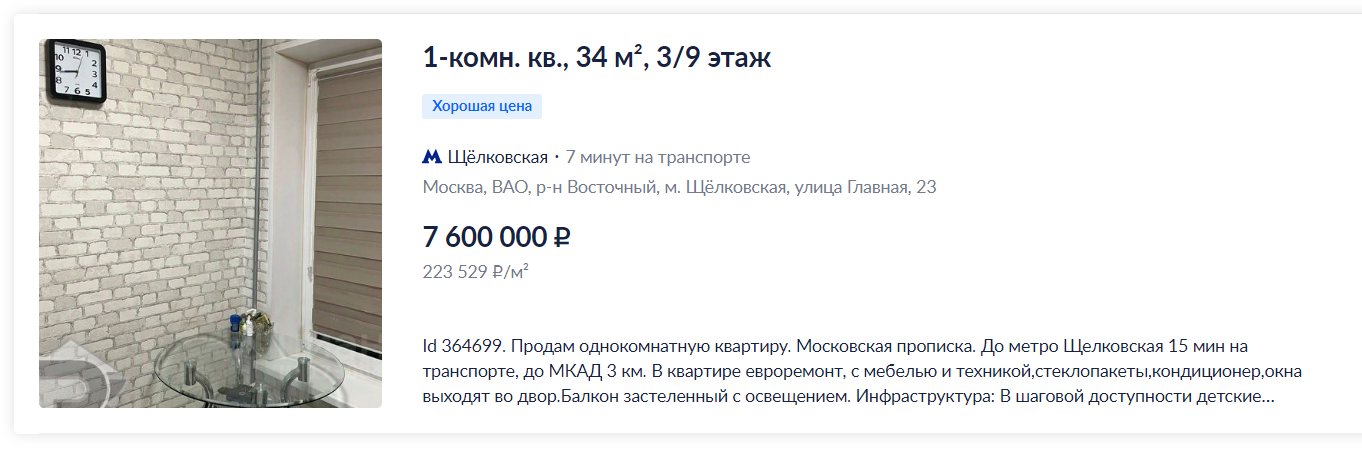
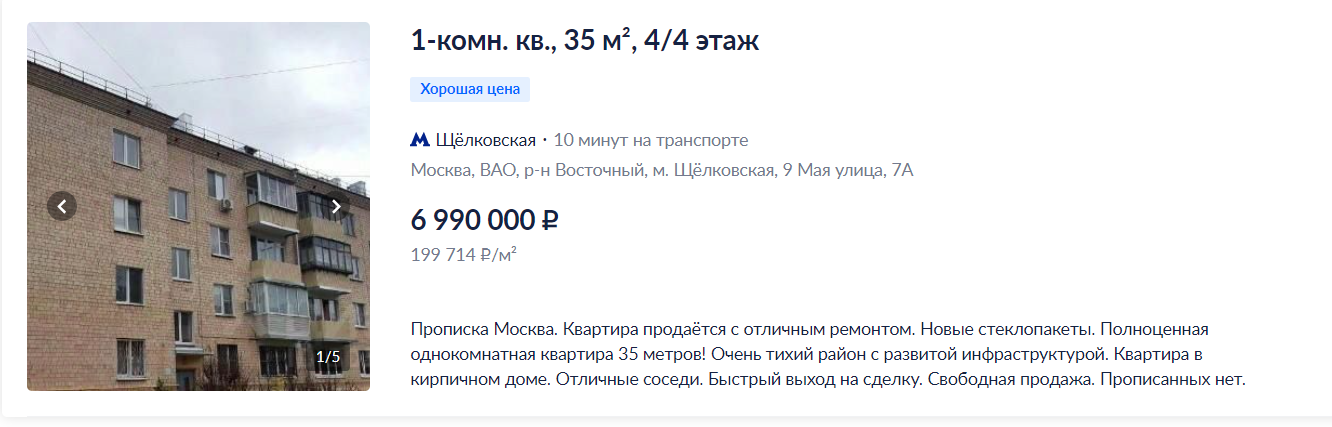
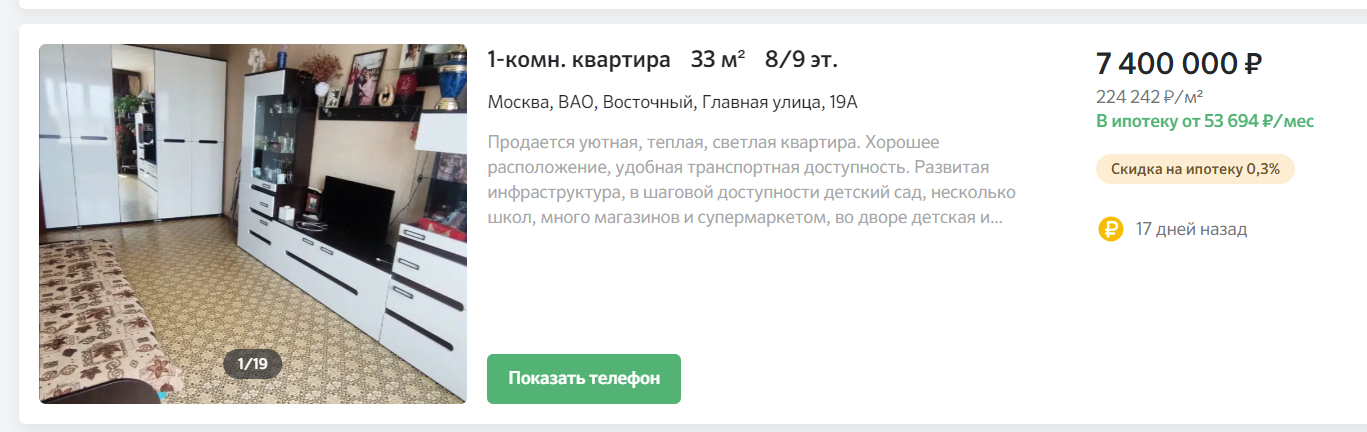
p.s. 2 объявления с циана, 1 - с домклик (на 05.07.2023)

In [31]:
# создадим словарь с параметрами нашей квартиры
apartment_params = {
    'building_type': 1,
    'level': 5,
    'levels': 7,
    'rooms': 1,
    'area': 34,
    'kitchen_area': 7,  
    'object_type': 1,
    'year': 2023,
    'month': 7,
    'day': 5,
    'level_to_levels': 5 / 7,
    'avg_room_size': 34 / 1,
    'kitchen_share': 7 / 34,
    'dist_to_center_of_Moscow': 24
}

# создадим датафрейм
apartment = pd.DataFrame(apartment_params, index=['value']).T

apartment

,value
building_type,1.000000
level,5.000000
levels,7.000000
rooms,1.000000
area,34.000000
kitchen_area,7.000000
object_type,1.000000
year,2023.000000
month,7.000000
day,5.000000


In [32]:
# объединим два датафрейма
full_df = apartment.merge(coeffs, left_index=True, right_index=True)
full_df

,value,coefs
building_type,1.000000,2.762167e+04
level,5.000000,8.985454e+03
levels,7.000000,6.742925e+04
rooms,1.000000,-8.185418e+05
area,34.000000,1.030086e+05
kitchen_area,7.000000,5.212126e+04
object_type,1.000000,-1.174195e+09
year,2023.000000,5.825820e+05
month,7.000000,3.794804e+04
day,5.000000,-2.169588e+01


In [33]:
# перемножим столбцы, чтобы узнать на сколько каждый признак изменяет итоговую цену квартиры
full_df['final_price'] = full_df['coefs'] * full_df['value']
full_df = full_df[['final_price']]
full_df

,final_price
building_type,2.762167e+04
level,4.492727e+04
levels,4.720047e+05
rooms,-8.185418e+05
area,3.502291e+06
kitchen_area,3.648488e+05
object_type,-1.174195e+09
year,1.178563e+09
month,2.656363e+05
day,-1.084794e+02


In [34]:
price = full_df.sum()

Итоговая стоимость квартиры получилась 5.7 млн. руб., но стоит также учесть инфляцию в 2021 году (8%) и 2022 году (12%), тогда получим:

In [35]:
price_adjusted_for_inflation = price * 1.08 * 1.12
price_adjusted_for_inflation

final_price    6.898663e+06
dtype: float64

In [36]:
# аналогичное, но короче :)
apartment = apartment.T
result = lin_model.predict(apartment)
result[0] * 1.08 * 1.12

6898663.477418666

Близкое соответствие между предсказаниями модели и реальной стоимостью квартиры свидетельствует о том, что модель может быть полезным инструментом для оценки цены недвижимости. Она может быть использована для принятия решений о покупке или продаже квартир, оценке инвестиционной привлекательности недвижимости или проведении анализа рынка недвижимости.

Конечно для более точной оценки следует использовать более сложные модели (градиентный бустинг или нейросети) и более актуальный датасет.

## Метод главных компонент

In [37]:
from sklearn.decomposition import PCA
model = PCA()
x = moscow_df.drop('price', axis=1)
model.fit(x)
X_2D = model.transform(x)

In [38]:
lin_model_after_PCA = LinearRegression()
y = moscow_df['price']
X_train, X_test, Y_train, Y_test = train_test_split(X_2D, y, train_size=0.7, random_state=1)

In [39]:
lin_model_after_PCA.fit(X_train, Y_train)

LinearRegression()

In [40]:
y_fit = lin_model_after_PCA.predict(X_test)
r2_score(Y_test, abs(y_fit))

0.6984524105999561

# Gradient Boosting

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
x = moscow_df.drop('price', axis=1)
y = moscow_df['price']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.7, random_state=1)
GB = GradientBoostingRegressor()

In [55]:
%%time

GB.fit(X_train, Y_train)

CPU times: total: 38 s
Wall time: 38.8 s


GradientBoostingRegressor()

In [56]:
Y_pred = GB.predict(X_test)

In [57]:
print(f"R^2={r2_score(Y_test, Y_pred).round(3)}")
print(f"MSE={mean_squared_error(Y_test, Y_pred)}")

R^2=0.794
MSE=1398771791046.9683


In [65]:
score = cross_val_score(GB, x, y, cv=5)
score

array([0.73358564, 0.78121845, 0.79501479, 0.76097297, 0.63803574])

# Hist Gradient Boosting

In [61]:
from sklearn.ensemble import HistGradientBoostingRegressor
x = moscow_df.drop('price', axis=1)
y = moscow_df['price']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.7, random_state=1)
hist_GB = HistGradientBoostingRegressor()

In [59]:
%%time

hist_GB.fit(X_train, Y_train)
Y_pred = hist_GB.predict(X_test)

CPU times: total: 12.2 s
Wall time: 1.91 s


In [60]:
print(f"R^2={r2_score(Y_test, Y_pred).round(3)}")
print(f"MSE={mean_squared_error(Y_test, Y_pred)}")

R^2=0.818
MSE=1238471949477.5356


In [63]:
# используя кросс-валидацию
from sklearn.model_selection import cross_val_score
score = cross_val_score(hist_GB, x, y, cv=5)
score

array([0.75160145, 0.79690507, 0.80719708, 0.7844513 , 0.66552982])

# Random forest

In [44]:
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(100)
x = moscow_df.drop('price', axis=1)
y = moscow_df['price']
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.7, random_state=1)

In [45]:
%%time
RF.fit(X_train, Y_train)

CPU times: total: 3min 24s
Wall time: 3min 25s


RandomForestRegressor()

In [46]:
Y_predicted = RF.predict(X_test)

In [51]:
print(f"R^2={r2_score(Y_test, Y_predicted).round(3)}")
print(f"MSE={mean_squared_error(Y_test, Y_predicted)}")

R^2=0.849
MSE=1026611284481.0642


In [48]:
apartm_price = RF.predict(apartment)

In [49]:
apartm_price[0] * 1.08 * 1.12

6723051.136704002

**Случайный лес показал наилучший результат из рассмотренных моделей, показав коэффициент детерминации равный 0.849 и MSE в 2 раза меньше линейной регрессии.**